In [1]:
import numpy as np
import matplotlib.pyplot as plt

# settings
%matplotlib inline

# Helper functions

In [2]:
def load_series_from_txt_file(filename):
    
    """
    Takes in a filename for a time series stored as .txt file, each line is an item.
    Load and convert to a numpy array, return the numpy array.
    """
    
    with open(filename) as file:
        content = file.read()
        
    # clean whitespaces
    content = content.strip()
    
    # split lines to a python list
    arr = content.splitlines()
        
    # convert arr to a numpy array and return it
    return np.array(arr, dtype=np.float64) 

In [3]:
def conv(f, g):
    
    """
    Perform convolution for series f and g
    
    Parameters
    ----------
    f, g: array-like
        List of numbers
    """
    
    # cast to numpy arrays to perform vectorized operations
    f = np.array(f)
    g = np.array(g)
    
    n = len(f)
    m = len(g)
    
    # initialize a zero valued array for output
    y = np.zeros(m+n-1)
    
    for i in range(n):
        
        # multiply g by ith element of f
        yi = f[i] * g
        
        # pad array with zeros for unused indicies
        yi = np.pad(yi, (i,n-i-1), "constant")
        
        # add to final result
        y += yi
        
    return y

In [4]:
def cross_corr(f, g):
    
    """
    Perform cyclic cross correlation of series f with series g
    
    Parameters
    ----------
    f, g: array-like
        List of numbers
    """
    return conv(f, g[::-1])

In [5]:
def cyc_conv(f, g):
    
    """
    Perform a cyclic convolution for f and g
    
    Parameters
    ----------
    
    f, g: array-like
    """
    
    # check length of f and g
    m = len(f)
    n = len(g)
    
    
    # if f and g are not of the same length, zero padding is needed
    if m != n:
        N = m + n - 1
        f = np.pad(f, (0, N - m))
        g = np.pad(g, (0, N - n))
    else:
        N = m
        
        
    # initialize an array for results
    h = np.zeros(N)

    for i in range(N):
        h[i] = sum([f[j] * g[(i-j)%N] for j in range(N)])
        
    return h

In [6]:
def cyc_cross_corr(f, g):
    
    """
    Perform cyclic cross correlation of series f with series g
    
    Parameters
    ----------
    f, g: array-like
        List of numbers
    """
    return cyc_conv(f, g[::-1])

In [7]:
def dft(x):
    
    """
    Perfom DFT for x
    
    Parameters
    ----------
    x: array-like
    """
    
    N = len(x)
    
    # array for results
    X = np.zeros(N, dtype=complex)
    
    # define exponent factor
    W = np.exp(-1j * (2*np.pi / N))
    
    for k in range(N):
        
        X[k] = sum([x[n]*(W**(k*n)) for n in range(N)])
        
    return X

In [8]:
def idft(X):
    
    """
    Inverse DFT for X
    
    Parameters
    ----------
    X: array-like
    """
    
    N = len(X)
    
    # array for results
    x = np.zeros(N, dtype=complex)
    
    # define exponent factor
    W = np.exp(-1j * (2*np.pi / N))
    
    for n in range(N):
        
        x[n] = sum([X[k]*(W**(-k*n)) for k in range(N)]) / N
        
    return x

In [9]:
def cc_xaxis(signal):
    
    """
    Create a series of x axis indicies appropriate for cross correlation.
    The values in x axis represent the signal shift in index
    """
    
    n = len(signal)
    lag = np.arange(-(n//2), (n//2)+1)
    
    return lag

In [10]:
def dft_freq_axis(spectrum, dt):
    
    """
    Parameters
    ----------
    spectrum:
        A series of numbers outputed from dft
    """
    
    # Nyquist freqeucny
    f_nyq = 1/(2*dt)
    
    # detemine frequeny axis spacing
    return np.linspace(0, f_nyq, len(spectrum))    

-----
# Code

## Load files

In [11]:
plt.rcParams["figure.figsize"] = (12,6.667)

filenames = ["A.txt", "B.txt", "WAVELT1.txt", "WAVELT2.txt"]

# sampling spacing
dt = 0.004

# load files as numpy arrays in a list comprehension, unpack list items to variables named a, b, w1, w2
a, b, w1, w2 = [load_series_from_txt_file(f) for f in filenames]

## Convolution

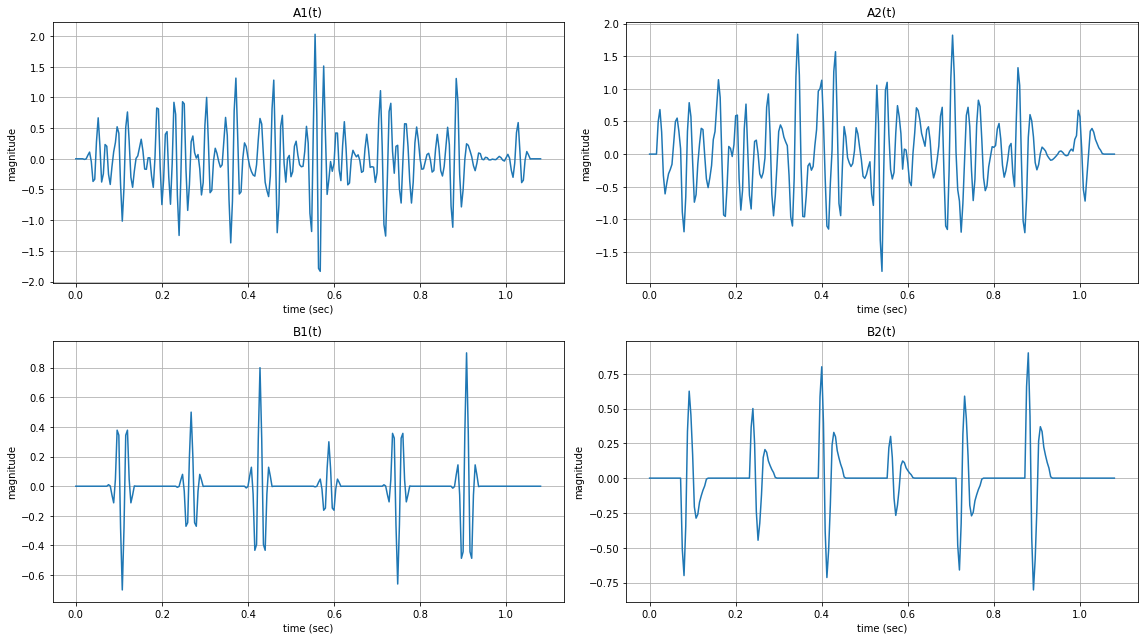

In [12]:
# perform convolution of the two time series, with each of the wavelets
a1 = conv(a, w1)
a2 = conv(a, w2)
b1 = conv(b, w1)
b2 = conv(b, w2)

# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))

for ax, trace in zip(ax.ravel(), ["a1", "a2", "b1", "b2"]):
    
    y = eval(trace)
    t = np.arange(0, len(y)*dt, dt)
    ax.plot(t ,y)
    
    ax.title.set_text(trace.upper()+"(t)")
    ax.set(xlabel="time (sec)", ylabel="magnitude")
    ax.grid()

plt.tight_layout()
# plt.savefig("1.png")

## Cross correlate

[Text(0, 0.5, 'magnitude'), Text(0.5, 0, 'time shift (sec)')]

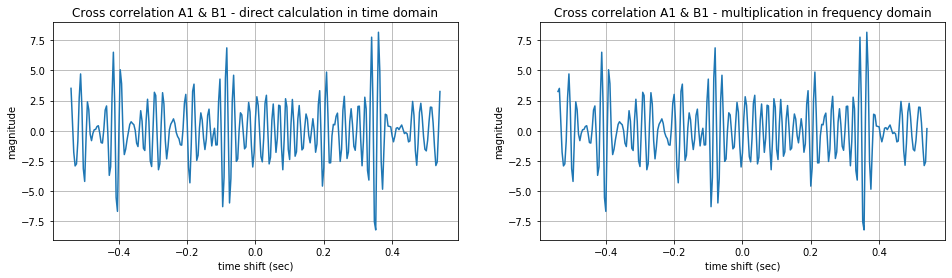

In [13]:
# cross correlation in time domain
cc_t = cyc_cross_corr(a1, b1)

# calculate the dft of a1 and b1
A1 = dft(a1)
B1 = dft(b1)

# multiply A1 and B1 conjugate in frequency domain, then perform inverse dft to obtain cross correlation
cc_f = idft(A1 * B1.conj())


# plot results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))

# x axis for cross correlation - the shift in seconds
tau = cc_xaxis(cc_t) * dt

# plot first subplot
ax1.plot(tau, cc_t)
ax1.grid()
ax1.title.set_text("Cross correlation A1 & B1 - direct calculation in time domain")
ax1.set(xlabel="time shift (sec)", ylabel="magnitude")

# plot second subplot
ax2.plot(tau, np.real(cc_f))
ax2.grid()
ax2.title.set_text("Cross correlation A1 & B1 - multiplication in frequency domain")
ax2.set(xlabel="time shift (sec)", ylabel="magnitude")

# plt.show()
# plt.savefig("2.png")

## Auto correlation

[Text(0, 0.5, 'magnitude'), Text(0.5, 0, 'time shift (sec)')]

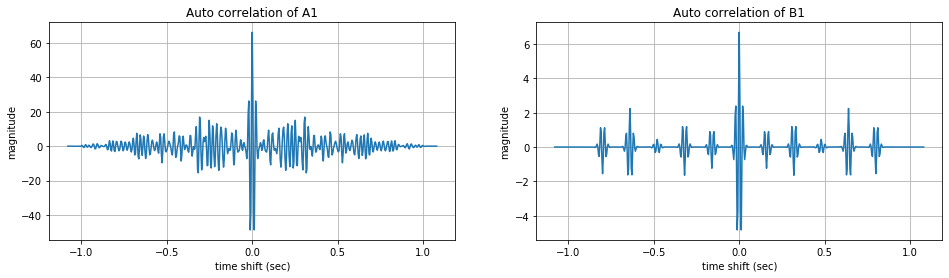

In [14]:
# perform auto correlation for a1 and b1
a1_ac = cross_corr(a1, a1)
b1_ac = cross_corr(b1, b1)


# plot results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,4))

# plot first subplot
ax1.plot(cc_xaxis(a1_ac) * dt, a1_ac)
ax1.grid()
ax1.title.set_text("Auto correlation of A1")
ax1.set(xlabel="time shift (sec)", ylabel="magnitude")

# plot second subplot
ax2.plot(cc_xaxis(b1_ac) * dt, b1_ac)
ax2.grid()
ax2.title.set_text("Auto correlation of B1")
ax2.set(xlabel="time shift (sec)", ylabel="magnitude")

# plt.show()
# plt.savefig("3.png")

## Resampling

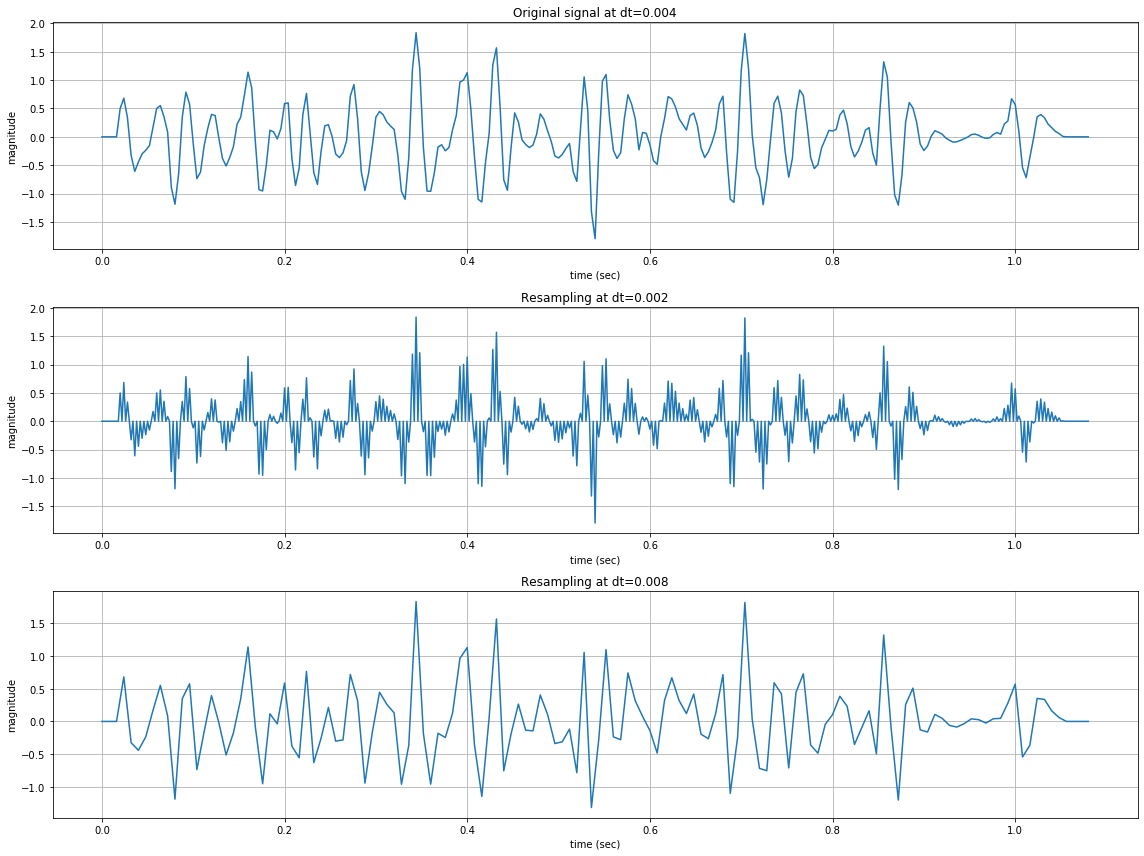

In [15]:
# resample from dt=0.004 to dt=0.002 - zero padding in between every two elements of a2
a2_0002 = np.zeros(2*len(a2) - 1)
a2_0002[::2] = a2
t_0002 = np.arange(len(a2_0002)) * 0.002

# resample from dt=0.004 to dt=0.008 - remove all elements in even index
a2_0008 = a2[::2]
t_0008 = np.arange(len(a2_0008)) * 0.008

# plot results
fig, ax = plt.subplots(nrows=3, figsize=(16,12))

traces = [(t, a2, "Original signal at dt=0.004"), 
          (t_0002, a2_0002, "Resampling at dt=0.002"), 
          (t_0008, a2_0008, "Resampling at dt=0.008")]

for i in range(len(ax)):
    x = traces[i][0]
    y = traces[i][1]
    title = traces[i][2]
    ax[i].plot(x, y)
    ax[i].grid()
    ax[i].title.set_text(title)
    ax[i].set(xlabel="time (sec)", ylabel="magnitude")
    

plt.tight_layout()
# plt.show()
# plt.savefig("4.png")

## Amplitude spectrum in freqeuncy domain

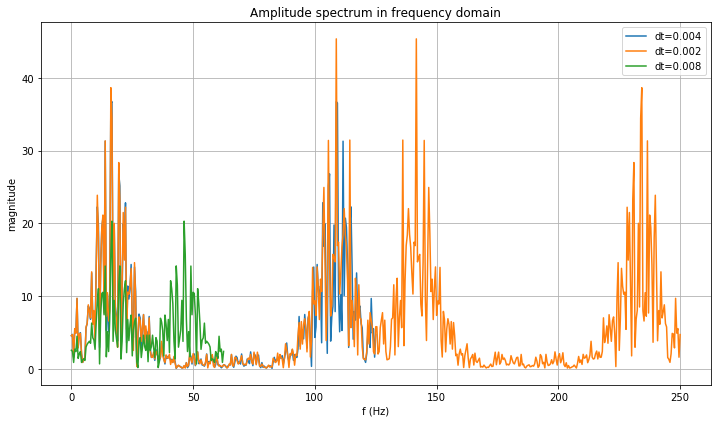

In [16]:
A2 = dft(a2)
freq = dft_freq_axis(A2, 0.004)

A2_0002 = dft(a2_0002)
freq_0002 = dft_freq_axis(A2_0002, 0.002)

A2_0008 = dft(a2_0008)
freq_0008 = dft_freq_axis(A2_0008, 0.008)


plt.plot(freq, np.abs(A2))
plt.plot(freq_0002, np.abs(A2_0002))
plt.plot(freq_0008, np.abs(A2_0008))

plt.title("Amplitude spectrum in frequency domain")
plt.xlabel("f (Hz)")
plt.ylabel("magnitude")
plt.legend(["dt=0.004", "dt=0.002", "dt=0.008"])
plt.grid()
# plt.show()
# plt.savefig("5.png")

## LPF for undersampled a2

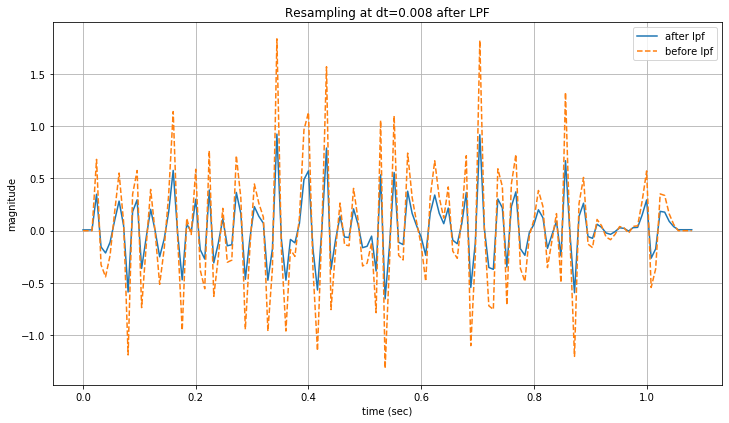

In [17]:
# first filter original a2 in frequency domain
# the nyquist frequency for dt=0.008 is 62.5 Hz, which is in the middle of array A2, index 135

# replace all items above 62.5 Hz with zeros
A2[135:] = 0

# perform dft
a2_filtered = idft(A2)

# undersample a2_filtered
a2_0008_lpf = a2_filtered[::2]
t_0008_lpf = np.arange(len(a2_0008_lpf)) * 0.008

plt.plot(t_0008_lpf, a2_0008_lpf.real, label="after lpf")
plt.plot(t_0008, a2_0008, "--", label="before lpf")

plt.xlabel("time (sec)")
plt.ylabel("magnitude")
plt.grid()
plt.title("Resampling at dt=0.008 after LPF")
plt.legend()
# plt.show()
# plt.savefig("6.png")

## Wavelets analysis

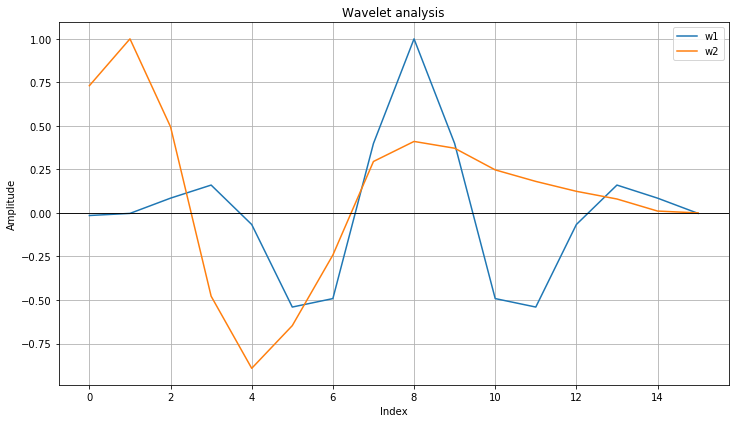

In [18]:
plt.figure(figsize=(12,6.667))
plt.plot(w1)
plt.plot(w2)

plt.axhline(c="k", linewidth=0.9)
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid()
plt.title("Wavelet analysis")
plt.legend(["w1", "w2"])
# plt.show()
# plt.savefig("7.png")

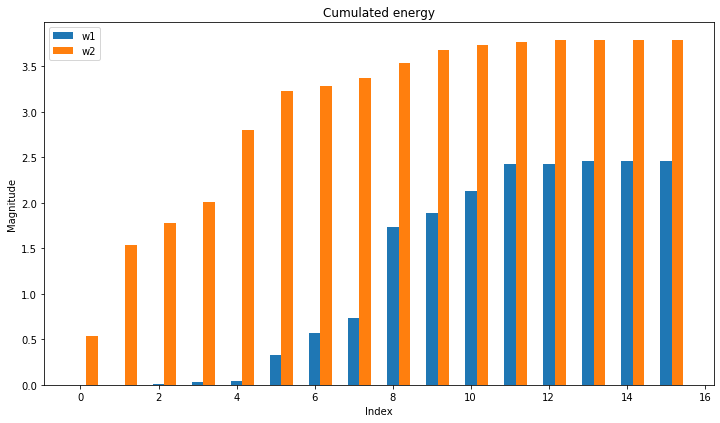

In [38]:
index = np.arange(len(w1))
width = 0.3

plt.bar(index, np.cumsum(w1**2), width, label="w1")
plt.bar(index+width, np.cumsum(w2**2), width, label="w2")

plt.xlabel("Index")
plt.ylabel("Magnitude")

plt.title("Cumulated energy")
plt.legend()
# plt.savefig("8.png")

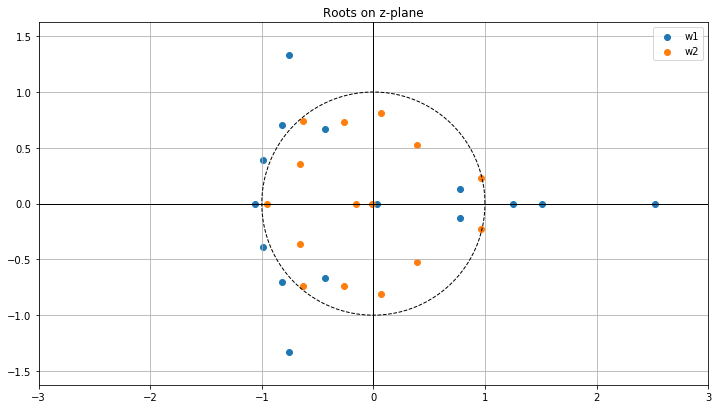

In [19]:
w1_roots = np.roots(w1)
w2_roots = np.roots(w2)

plt.scatter(w1_roots.real, w1_roots.imag, label="w1")
plt.scatter(w2_roots.real, w2_roots.imag, label="w2")

# unit circle
theta = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(theta), np.sin(theta), linewidth=1, c="k", linestyle="--")

# aesthetics
plt.axhline(c="k", linewidth=1)
plt.axvline(c="k", linewidth=1)
plt.grid()
plt.axis("equal")
plt.xlim((-3,3))
plt.ylim((-2,2))

plt.title("Roots on z-plane")
plt.legend()
# plt.show()
# plt.savefig("9.png")